# MNIST Classification
Inspired by https://www.kaggle.com/ashwani07/mnist-classification-using-random-forest

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt  #Graphics
import numpy as np
import pandas as pd
import requests
import warnings
import seaborn as sns
from sklearn import svm
from pprint import pprint
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold,cross_val_score,StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
#To show graphs within the notebook
%matplotlib inline
warnings.filterwarnings('ignore')


## Download Dataset

In [2]:
mnist_file = 'mnist.csv'
mnist_file_path = Path(mnist_file)
if not mnist_file_path.is_file():
    # file exists
    print('Dataset does not exist. Downloading...')
    csv_url = 'https://raw.githubusercontent.com/MSc-in-Data-Science/class_material/master/semester_1/Machine_Learning/datasets/digit_recognizer_dataset.csv'
    req = requests.get(csv_url)
    url_content = req.content
    csv_file = open('mnist.csv', 'wb')
    csv_file.write(url_content)
    csv_file.close()
    print('Dataset Downloaded')
else:
    print('Dataset exists')

Dataset exists


In [3]:
#load the datasets
train = pd.read_csv("mnist.csv").astype('uint8')
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]-1))

Training dataset has 42000 observations and 784 variables


In [4]:
#check few rows
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#Seperate the target and independant variables
df_x=train.iloc[:,1:]
df_y=train.iloc[:,0]

In [6]:
def print_image(row, df):
    temp=df.iloc[row,:].values
    temp = temp.reshape(28,28).astype('uint8')
    plt.imshow(temp)

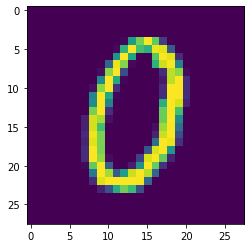

In [7]:
print_image(5, df_x)

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

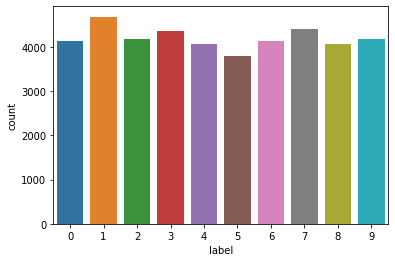

In [8]:
#Check the frequency of each number
sns.countplot(df_y)
df_y.value_counts().sort_index()

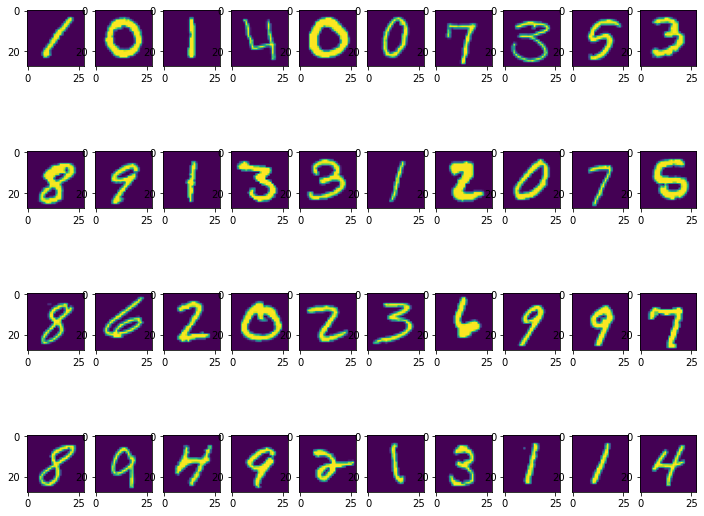

In [9]:
# Print some of the digits/images to inspect the dataset
plt.figure(figsize=(12,10))
for i in range(40):
    plt.subplot(4, 10, i+1)
    print_image(i, df_x)

In [10]:
#Split the dataset

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42, stratify=df_y)
print(X_train.shape)
print(X_test.shape)

(29400, 784)
(12600, 784)


In [11]:
def accuracy_per_class(target_test, pred):
    matrix = confusion_matrix(target_test, pred)
    acc_per_class = matrix.diagonal()/matrix.sum(axis=1)
    acc_per_class_dict = {i:v for i,v in enumerate(acc_per_class)}
    return acc_per_class_dict
    

def classification_report_for_cv(target_test, pred):
    print ("Classification Report")
    print(classification_report(target_test, pred))
    return accuracy_score(target_test, pred)

def general_classification_report(target_test, pred):
    """
    General Classification Report
    :param target_test: target test data
    :param pred: the prediction of the classifier
    """
    print ("Classification Report")
    print(classification_report(target_test, pred))
    print("Accuracy per class")
    pprint(accuracy_per_class(target_test, pred))
    cmrforest = confusion_matrix(target_test , pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cmrforest ,annot=True , fmt = 'd')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('Confusion Report')

def perform_classification_with_grid_search(clf_name, data_train, data_test, target_train, target_test, cv=10):
    """
    Function that uses several classifiers with parameter tuning
    :param clf_name: Classifier name, can be Random Forest, SVM, kNN, Logistic Regression
    :param data_train: train data
    :param data_test: test data
    :param target_train: target train data
    :param target_test: target test data
    :param cv: number of folds
    :return: A dictionary with the best parameters
    """
    if clf_name=='Random Forest':
        param_grid = {
            'n_estimators': [200],
            'max_features': ['auto'],
            'max_depth' : [4,5,6,7,8],
            'criterion' :['gini', 'entropy']
        }
        clf = RandomForestClassifier(random_state=42)

    elif clf_name=='SVM':
        param_grid = {
            'kernel': ['rbf'],
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000]
            }
        clf = svm.SVC()

    elif clf_name=='kNN':
        param_grid = {'n_neighbors': range(1, 31)}
        clf = KNeighborsClassifier()

    elif clf_name=='Logistic Regression':
        param_grid = {"C": np.logspace(-3,3,7),
                      "penalty": ["l1","l2"]}
        clf = LogisticRegression()

    else:
        print('Provide one of the available classifiers: Random Forest, SVM, kNN, Logistic Regression')
        return

    cv_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv)
    cv_rfc.fit(data_train, target_train)
     # Viewing The Best Parameters
    print('Best Parameters: ', cv_rfc.best_params_)
    print('Best Accuracy Score Achieved in Grid Search: ', cv_rfc.best_score_)
    best_estimator = cv_rfc.best_estimator_
    # Predicting using the best estimator
    best_estimator.fit(data_train, target_train)
    pred=best_estimator.predict(data_test)
    general_classification_report(target_test, pred)
    best_estimator.score(data_test, target_test)

def perform_classification(clf_name, data_train, data_test, target_train, target_test):
    """
    Function that uses several classifiers
    :param clf_name: Classifier name, can be Random Forest, SVM rbf, SVM linear, kNN, Logistic Regression
    :param data_train: train data
    :param data_test: test data
    :param target_train: target train data
    :param target_test: target test data
    """
    if clf_name=='Random Forest':
        clf=RandomForestClassifier(n_estimators=100)

    elif clf_name=='SVM rbf':
        clf = svm.SVC(kernel='rbf')

    elif clf_name=='kNN':
        clf = KNeighborsClassifier()

    elif clf_name=='Logistic Regression':
        clf = LogisticRegression()

    else:
        print('Provide one of the available classifiers: Random Forest, SVM, kNN, Logistic Regression')
        return

    clf.fit(data_train, target_train)
    pred=clf.predict(data_test)
    general_classification_report(target_test, pred)
#     clf.score(data_test,  target_test)

def perform_classification_with_cv(clf_name, X, y):
    """
    Function that uses several classifiers
    :param clf_name: Classifier name, can be Random Forest, SVM rbf, SVM linear, kNN, Logistic Regression
    :param data_train: train data
    :param data_test: test data
    :param target_train: target train data
    :param target_test: target test data
    """
    if clf_name=='Random Forest':
        clf=RandomForestClassifier(n_estimators=100)

    elif clf_name=='SVM rbf':
        clf = svm.SVC(kernel='rbf')

    elif clf_name=='kNN':
        clf = KNeighborsClassifier()

    elif clf_name=='Logistic Regression':
        clf = LogisticRegression()

    else:
        print('Provide one of the available classifiers: Random Forest, SVM, kNN, Logistic Regression')
        return
    
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    nested_score = cross_val_score(clf, X=X, y=y, cv=cv, \
                   scoring=make_scorer(classification_report_for_cv))
    print("Accuracy per class")
    pprint(nested_score) 
    

In [12]:
def perform_cross_validation(clf_name, X,y, feature_selection=None):
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=42)

    accuracy = 0
    precision = 0
    recall = 0
    f1 = 0
    X = X.to_numpy()
    y = y.to_numpy()
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        if feature_selection=='pca':
            fs = PCA(n_components=0.95).fit(X_train)
            X_train = fs.transform(X_train)
            X_test = fs.transform(X_test) 
        elif feature_selection=='selectKbest':
            fs = SelectKBest(score_func=chi2, k=200).fit(X_train, y_train)
            X_train = fs.transform(X_train)
            X_test = fs.transform(X_test)

        # X_train, X_test, y_train, y_test = train_test_split( feature_array, label_array, test_size = 0.3,stratify=label_array, random_state = 100)
        if clf_name=='Random Forest':
            clf=RandomForestClassifier(n_estimators=100)

        elif clf_name=='SVM rbf':
            clf = svm.SVC(kernel='rbf')

        elif clf_name=='kNN':
            clf = KNeighborsClassifier()

        elif clf_name=='Logistic Regression':
            clf = LogisticRegression()

        else:
            print('Provide one of the available classifiers: Random Forest, SVM, kNN, Logistic Regression')
            return
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)


        accuracy += accuracy_score(y_test, y_pred)*100
        precision += precision_score(y_test, y_pred,average='macro')*100
        recall += recall_score(y_test, y_pred, average='macro')*100
        f1 += f1_score(y_test, y_pred, average='macro')*100


    print("Average Accuracy:", accuracy/10)
    print("Macro-Average Precision:", precision/10)
    print("Macro-Average Recall:", recall/10)
    print("Macro-Average F1 score:", f1/10)


## Classfication without feature selection/reduction

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1240
           1       0.95      0.98      0.96      1405
           2       0.90      0.89      0.89      1253
           3       0.89      0.89      0.89      1305
           4       0.92      0.92      0.92      1222
           5       0.88      0.83      0.85      1139
           6       0.93      0.96      0.95      1241
           7       0.93      0.92      0.93      1320
           8       0.85      0.85      0.85      1219
           9       0.87      0.89      0.88      1256

    accuracy                           0.91     12600
   macro avg       0.91      0.91      0.91     12600
weighted avg       0.91      0.91      0.91     12600

Accuracy per class
{0: 0.9540322580645161,
 1: 0.9765124555160143,
 2: 0.8906624102154829,
 3: 0.8881226053639847,
 4: 0.9165302782324058,
 5: 0.8331870061457419,
 6: 0.9572925060435133,
 7: 0.921969696969697,
 8: 0.851

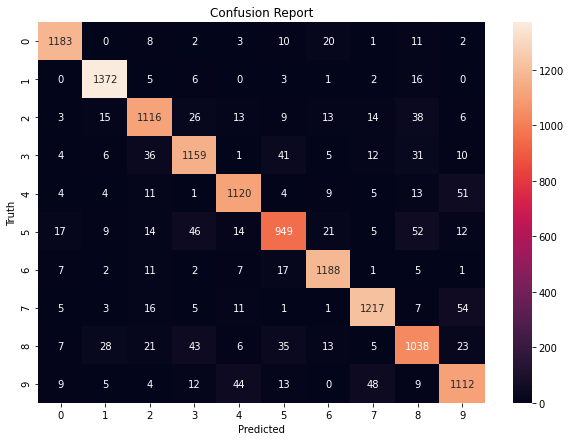

In [13]:
perform_classification('Logistic Regression', X_train, X_test, y_train, y_test)

In [ ]:
perform_cross_validation('Logistic Regression', df_x, df_y)

In [ ]:
perform_classification('kNN', X_train, X_test, y_train, y_test)

In [ ]:
perform_cross_validation('kNN', df_x, df_y)

In [ ]:
perform_classification('SVM rbf', X_train, X_test, y_train, y_test)

In [ ]:
perform_cross_validation('SVM rbf', df_x, df_y)

In [ ]:
perform_classification('Random Forest', X_train, X_test, y_train, y_test)

In [ ]:
perform_cross_validation('Random Forest', df_x, df_y)

### PCA

In [ ]:
# feature extraction
# n_components=100
# scaler = MinMaxScaler()
# X_train_rescaled = scaler.fit_transform(X_train)
pca = PCA(n_components = 0.95)
pca.fit(X_train)

# fig, ax = plt.subplots()

# plt.xlim(0.0,800.0)
# plt.ylim(0.0,1.1)

# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# ax.plot(np.cumsum(pca.explained_variance_ratio_), color='b')
# ax.axhline(y=0.95, color='r', linestyle='dotted')
# ax.text(100, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)


X_train_new = pca.transform(X_train)
X_test_new = pca.transform(X_test)
print(X_train_new.shape)
print(X_test_new.shape)

In [ ]:
# scaler = MinMaxScaler()
# scaler.fit_transform(X_train)
# pca = PCA().fit(X_train_rescaled)
pca = PCA().fit(X_train)


# plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 785, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 785, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='dotted')
plt.text(300, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)

ax.grid()
plt.show()

### Classification

In [ ]:
# perform_cross_validation('Logistic Regression', df_x, df_y,  'pca')

In [ ]:
perform_classification('Logistic Regression', X_train_new, X_test_new, y_train, y_test)

In [ ]:
perform_classification('kNN', X_train_new, X_test_new, y_train, y_test)

In [ ]:
perform_classification('SVM rbf', X_train_new, X_test_new, y_train, y_test)

In [ ]:
perform_classification('Random Forest', X_train_new, X_test_new, y_train, y_test)

### Classification with grid search

In [ ]:
# perform_classification_with_grid_search('Random Forest', X_train_new, X_test_new, y_train, y_test)
# perform_classification_with_grid_search('kNN', X_train_new, X_test_new, y_train, y_test)
# perform_classification_with_grid_search('SVM', X_train_new, X_test_new, y_train, y_test)
# perform_classification_with_grid_search('Logistic Regression', X_train_new, X_test_new, y_train, y_test)

### Feature Selection

In [ ]:
best_features = SelectKBest(score_func=chi2, k=200)
fit = best_features.fit(X_train, y_train)
X_train_new = fit.transform(X_train)
X_test_new = fit.transform(X_test)

In [ ]:
perform_classification('Logistic Regression', X_train_new, X_test_new, y_train, y_test)

In [ ]:
perform_cross_validation('Logistic Regression', df_x, df_y,'selectKbest')

In [ ]:
perform_classification('kNN', X_train_new, X_test_new, y_train, y_test)

In [ ]:
perform_cross_validation('kNN', df_x, df_y,'selectKbest')

In [ ]:
perform_classification('SVM rbf', X_train_new, X_test_new, y_train, y_test)

In [ ]:
perform_cross_validation('SVM rbf', df_x, df_y,'selectKbest')

In [ ]:
perform_classification('Random Forest', X_train_new, X_test_new, y_train, y_test)

In [ ]:
perform_cross_validation('Random Forest', df_x, df_y,'selectKbest')